# BERT for Binary Bias Classification

This notebook uses [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) to train BERT on the [BABEv3 dataset](https://huggingface.co/datasets/mediabiasgroup/BABE).

Start by defining the training parameters in the cell below, then collapse this text cell and click the run button for all 26 cells. This will train BERT with your settings on the BABEv3 dataset, and evaluate it on the test split.

You can try the model out at the bottom and compare it to another popular model, [dbias](https://huggingface.co/d4data/bias-detection-model).


## 🌎 Setup Env


In [ ]:
#@title Define some things

MAX_TOKEN_LEN = 128 #@param
EPOCHS = 20 #@param
BATCH_SIZE = 16 #@param
PATIENCE = 3 #@param
BERT_MODEL_NAME = 'bert-base-uncased' #@param
BASE_LEARNING_RATE = 3e-4 #@param
WARMUP_EPOCHS = 7 #@param
NUM_TOP_BERT_LAYERS_FREEZE = 0 #@param
DROPOUT_PROB = 0.00 #@param

In [ ]:
#@title Install dependencies

# these could just be pip installs but this way you can run all the cells faster

#@title Install dependencies

import importlib
import subprocess

# Define the packages and their versions
packages = {
  'pytorch_lightning': '==2.4.0',
  'transformers': '==4.42.4',
  'pymysql': '',
  'torchmetrics': '==1.4.1',
  'datasets': '==2.20.0'
}

def install_package(package_name, version=None):
    try:
        importlib.import_module(package_name)
        print(f"{package_name} is already installed.")
    except ImportError:
        print(f"Installing {package_name}...")
        if version:
            subprocess.check_call(['pip', 'install', f'{package_name}{version}', '--quiet'])
        else:
            subprocess.check_call(['pip', 'install', package_name, '--quiet'])

for package, version in packages.items():
    install_package(package, version)

print("All packages are installed.")


Installing pytorch_lightning...
transformers is already installed.
Installing pymysql...
torchmetrics is already installed.
Installing datasets...
All packages are installed.


In [ ]:
#@title Env Config

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.classification import Accuracy, F1Score, AUROC
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

## ⚙️ Preprocess Data

In [ ]:
#@title Load BABE Training Dataset
from datasets import load_dataset

dataset = load_dataset("mediabiasgroup/BABE", split="train")
dataset = pd.DataFrame(dataset)
dataset.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3121 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

,text,outlet,label,topic,news_link,biased_words,uuid,type,label_opinion
0,NYPD Commissioner Dermot Shea on Monday expres...,Breitbart,0,marriage-equality,http://feedproxy.google.com/~r/breitbart/~3/F5...,[],GtvFWZmmQmybyeMnb8Wbsr,None,Entirely factual
1,School systems across the country are adopting...,Federalist,1,islam,https://thefederalist.com/2020/07/08/black-liv...,"['indoctrinating', 'Marxist', 'alarming']",mvoQPtabs6NZbby6LkLbms,None,Expresses writer’s opinion
2,"And then along came President Barry Obama, who...",Breitbart,1,marriage-equality,http://feedproxy.google.com/~r/breitbart/~3/ks...,"['what', 'the', 'hell']",RDWPbijx3n2aw6NiMHt7di,None,Expresses writer’s opinion
3,"The curfews, which have never before occurred ...",Alternet,1,elections-2020,https://www.alternet.org/2020/06/we-just-got-a...,"['false', 'claims']",2uYKw5KpXasJWH65WCjSu4,left,Entirely factual
4,"Rather than help be a part of the solution, Tr...",Alternet,1,elections-2020,https://www.alternet.org/2020/06/trump-thought...,['racist'],SRGvrzY9PkvtHESdts35Rw,left,Expresses writer’s opinion


In [ ]:
#@title Split into Training and Validation Sets

train_df, val_df = train_test_split(dataset, test_size=0.05, random_state=42)

print(f"Shape of train_df: {train_df.shape}")
print(f"Shape of val_df: {val_df.shape}")

Shape of train_df: (2964, 9)
Shape of val_df: (157, 9)


## 💽 Create Dataset (pl Data Module)

In [ ]:
#@title SocialBiasDataset (pt dataset module)

import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer
import pandas as pd

class SocialBiasDataset(Dataset):
    def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int = 128):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        text_str = data_row['text']
        label = data_row['label']

        # tokenize the text
        encoding = self.tokenizer.encode_plus(
            text_str,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return dict(
            text_str=text_str,
            input_ids=encoding["input_ids"].flatten(), # flatten to single dimension
            attention_mask=encoding["attention_mask"].flatten(), # flatten to single dimension
            label=torch.FloatTensor([label]) # turns the int into a tensor w it as the only valuse, still one dimension

          )

In [ ]:
#@title Define Dataset, and Examine Shape

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

train_dataset = SocialBiasDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_LEN
)

sample_item = train_dataset[0]
print(sample_item.keys(), "\n")
print(f"text_str: {sample_item['text_str']}")
print(f"input_ids shape: {sample_item['input_ids'].shape}")
print(f"attention_mask shape: {sample_item['attention_mask'].shape}")
print(f"labels shape: {sample_item['label'].shape} -- ex. {sample_item['label']}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

dict_keys(['text_str', 'input_ids', 'attention_mask', 'label']) 

text_str: This wasn’t a moment of anger where Keon called someone a racist or sexist name because he’d lost his temper or felt threatened.
input_ids shape: torch.Size([128])
attention_mask shape: torch.Size([128])
labels shape: torch.Size([1]) -- ex. tensor([1.])


In [ ]:
#@title PyTorch Lightning Data Module

class SocialBiasDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, tokenizer, batch_size=16, max_token_len=128):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        # use the pt datasets defined above
        self.train_dataset = SocialBiasDataset(self.train_df, self.tokenizer, self.max_token_len)
        self.test_dataset = SocialBiasDataset(self.test_df, self.tokenizer, self.max_token_len)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=4
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=4
        )

# init the data module
data_module = SocialBiasDataModule(
    train_df,
    val_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_LEN
)

## 🤖 Model Definition

In [ ]:
#@title LightningModule

#@markdown [LightningModule Doc](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html)

#@markdown [Linear Scheduler with Warmup](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.get_linear_schedule_with_warmup)

#@markdown Using BCE and AdamW optimizer

class SocialBiasClassifier(pl.LightningModule):
    def __init__(self, n_training_steps=None, n_warmup_steps=None, num_layers_to_freeze=0, dropout_prob=0.1):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(self.bert.config.hidden_size, 1)  # 1 neuron for binary classification
        )
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.loss_fn = nn.BCELoss()  # using binary cross entropy loss

        # freeze layers (wasn't useful in testing)
        self.freeze_bert_layers(num_layers_to_freeze)

        # metrics
        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.train_f1 = F1Score(task="binary")
        self.val_f1 = F1Score(task="binary")
        self.train_outputs = [] # used in train_auroc
        self.train_auroc = AUROC(task="binary")
        self.val_auroc = AUROC(task="binary")

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)

        # # mean pooling
        # attention_mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_states.size())
        # sum_hidden_states = torch.sum(hidden_states * attention_mask_expanded, dim=1)
        # num_tokens = torch.sum(attention_mask, dim=1).clamp(min=1)  # don't divide by 0
        # mean_pooled_output = sum_hidden_states / num_tokens.unsqueeze(-1)  # reshape num_tokens?

        output = self.classifier(output.pooler_output) # change this to mean_pooled_output if you uncomment the lines above
        output = torch.sigmoid(output).squeeze(-1)
        loss = 0
        if labels is not None:
            loss = self.loss_fn(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        # parse batch
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"].squeeze(-1)  # squeeze labels to match outputs shape

        # run forward pass
        loss, outputs = self(input_ids, attention_mask, labels)

        # metrics
        self.train_accuracy(outputs, labels.int())
        self.train_f1(outputs, labels.int())
        self.train_auroc(outputs, labels.int())
        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", self.train_accuracy, on_step=True, on_epoch=True)
        self.log("train_f1", self.train_f1, on_step=True, on_epoch=True)
        self.log("train_auroc", self.train_auroc, on_step=True, on_epoch=True)
        self.log("batch_size", input_ids.size(0), prog_bar=True, logger=True)
        self.train_outputs.append({"predictions": outputs, "labels": labels})

        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"].squeeze(-1)
        loss, outputs = self(input_ids, attention_mask, labels)
        self.val_accuracy(outputs, labels.int())
        self.val_f1(outputs, labels.int())
        self.val_auroc(outputs, labels.int())
        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", self.val_accuracy, on_step=True, on_epoch=True)
        self.log("val_f1", self.val_f1, on_step=True, on_epoch=True)
        self.log("val_auroc", self.val_auroc, on_step=True, on_epoch=True)
        self.log("batch_size", input_ids.size(0), prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"].squeeze(-1)
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("batch_size", input_ids.size(0), prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=BASE_LEARNING_RATE)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step"
            }
        }

    def on_train_epoch_end(self):
        labels = torch.cat([output["labels"] for output in self.train_outputs])
        predictions = torch.cat([output["predictions"] for output in self.train_outputs])
        class_roc_auc = self.train_auroc(predictions, labels.int())
        self.log('train_roc_auc', class_roc_auc, prog_bar=True, logger=True)
        self.train_outputs = []  # clear outputs for the next epoch

    # currently freezing top layers but we could try bottom
    def freeze_bert_layers(self, num_layers_to_freeze):
        for param in self.bert.parameters():
            param.requires_grad = True

        # Set requires_grad to False for the specified number of layers
        for i, layer in enumerate(self.bert.encoder.layer):
            if i < num_layers_to_freeze:
                for param in layer.parameters():
                    param.requires_grad = False


## 🧑‍🏫️ Training

### Setup Trainer

In [ ]:
#@title Fresh instance of our BERT + our Model Architecture

steps_per_epoch = len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * EPOCHS
warmup_percentage = WARMUP_EPOCHS / EPOCHS
warmup_steps = int(total_training_steps * warmup_percentage)
print("Warmup Steps:", warmup_steps)
print("Total Training Steps:", total_training_steps)

model = SocialBiasClassifier(
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps,
    num_layers_to_freeze=NUM_TOP_BERT_LAYERS_FREEZE,
    dropout_prob=DROPOUT_PROB
)
print("Model initialized")

Warmup Steps: 1295
Total Training Steps: 3700


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AttributeError: 'BertForSequenceClassification' object has no attribute 'encoder'

In [ ]:
#@title Define pt lightning Trainer

# callbacks for selecting the best checkpoint
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='social-bias-model/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    mode='min'
)

# logging for viewing in tensorboard
logger = TensorBoardLogger('lightning_logs', name='social-bias-model')

# pl trainer
trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=EPOCHS,
    log_every_n_steps=1,
)


In [ ]:
#@title Clear pytorch logs and stuff
!rm -rf lightning_logs/
!rm -rf checkpoints/

In [ ]:
#@title Start Tensorboard
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

### Start Training

In [ ]:
#@title Run training
trainer.fit(model, data_module)

## 📝 Evalutation

In [ ]:
#@title Load best model from checkpoint
trained_model = SocialBiasClassifier.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=1
)
trained_model.eval()
trained_model.freeze()

In [ ]:
#@title Load BABE Evaluation Dataset

from datasets import load_dataset

# load the test split from hf
dataset = load_dataset("mediabiasgroup/BABE", split="test")

# making sure
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

texts_list = []

# mostly for formatting correctly for testing
def preprocess_function(examples):
    encodings = tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=MAX_TOKEN_LEN,
    )
    encodings['labels'] = examples['label']
    texts_list.extend(examples['text'])
    return encodings

# apply preprocessing to the dataset into tokens and labels
encoded_dataset = dataset.map(preprocess_function, batched=True)

# convert the dataset to pytorch tensors
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# use encoded dataset in a dataloader
eval_dataloader = DataLoader(encoded_dataset, batch_size=16, shuffle=False)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

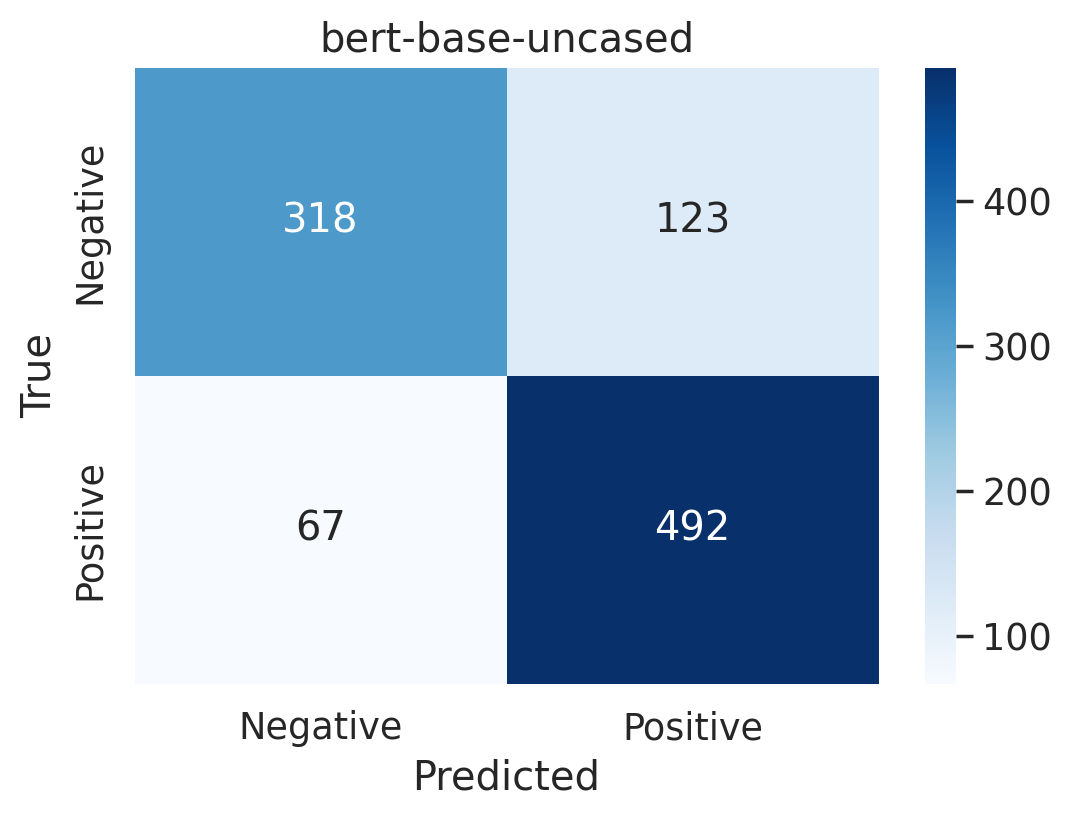


Classification Metrics for bert-base-uncased:
Accuracy:  0.8100
Precision: 0.8000
Recall:    0.8801
F1 Score:  0.8382


In [ ]:
#@title Evaluate Model and Create Confusion Matrix

threshold = 0.5 #@param

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model.to(device)

# need to store predictions and true labels
all_preds = []
all_labels = []

# run model on test set
with torch.no_grad():
    for batch in eval_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        _, outputs = trained_model(input_ids, attention_mask)

        # threshold rounding
        preds = (outputs > threshold).float().cpu().numpy() # outputs a list of 1.'s or 0.'s

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# convert lists to numpy arrays
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# calc the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print(f"Confusion Matrix:\n{cm}")

# plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'{BERT_MODEL_NAME}')
plt.show()

# calc eval metrics
precision = precision_score(all_labels, all_preds, pos_label=1)
recall = recall_score(all_labels, all_preds, pos_label=1)
f1 = f1_score(all_labels, all_preds, pos_label=1)
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, pos_label=1)

print(f"\nClassification Metrics for {BERT_MODEL_NAME}:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/657 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/268M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at d4data/bias-detection-model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


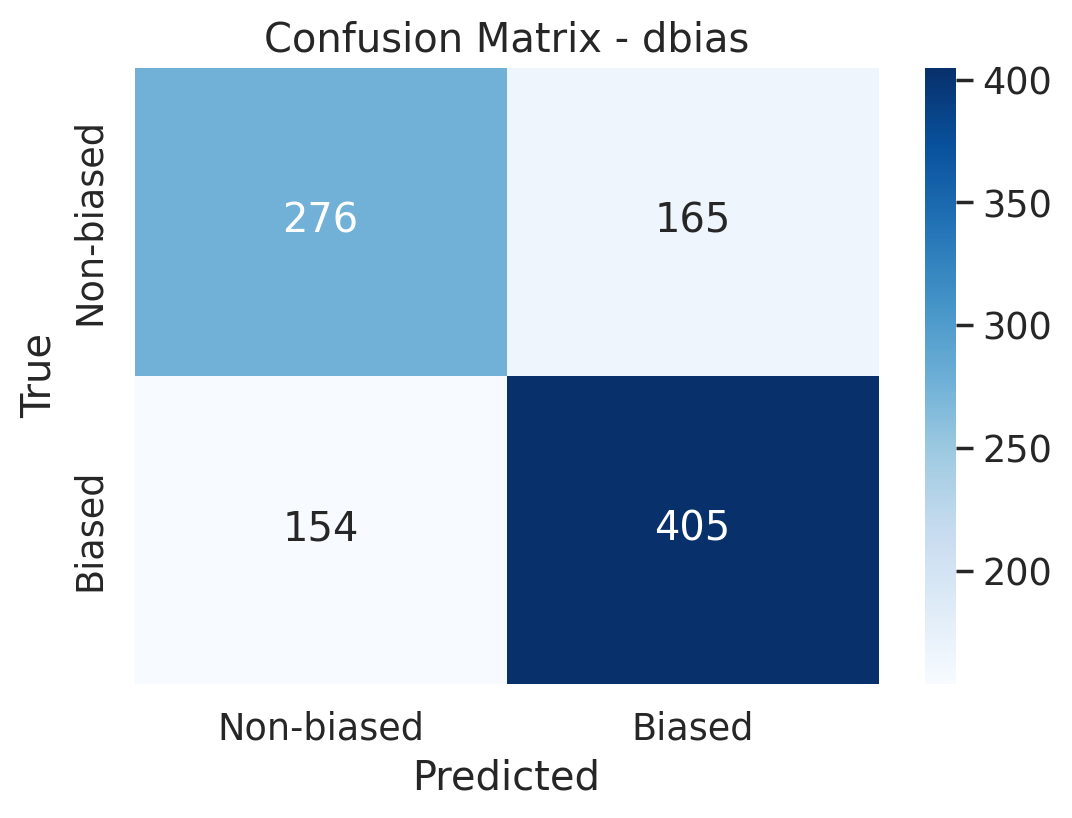

Confusion Matrix for Pre-trained Model:
[[276 165]
 [154 405]]

Classification Metrics for dbias model:
Accuracy:  0.6810
Precision: 0.7105
Recall:    0.7245
F1 Score:  0.7174


In [ ]:
#@title Evaluate DBias and Create Confusion Matrix

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, pipeline
import torch

tokenizer = AutoTokenizer.from_pretrained("d4data/bias-detection-model")
model = TFAutoModelForSequenceClassification.from_pretrained("d4data/bias-detection-model")
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

all_preds_pretrained = []
all_labels = encoded_dataset['labels'].tolist()

for text in texts_list:
    result = classifier(text, truncation=True, max_length=512)
    label = result[0]['label']
    preds = 1 if label == 'Biased' else 0
    all_preds_pretrained.append(preds)

all_preds_pretrained = np.array(all_preds_pretrained).flatten()
all_labels = np.array(all_labels).flatten()

cm_pretrained = confusion_matrix(all_labels, all_preds_pretrained)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_pretrained, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-biased', 'Biased'], yticklabels=['Non-biased', 'Biased'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - dbias')
plt.show()

print("Confusion Matrix for Pre-trained Model:")
print(cm_pretrained)

precision = precision_score(all_labels, all_preds_pretrained, pos_label=1)
recall = recall_score(all_labels, all_preds_pretrained, pos_label=1)
f1 = f1_score(all_labels, all_preds_pretrained, pos_label=1)
accuracy = accuracy_score(all_labels, all_preds_pretrained)

print("\nClassification Metrics for dbias model:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Try it

In [ ]:
#@title Try out dbias

import torch
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, pipeline

distil_bert_tokenizer = AutoTokenizer.from_pretrained("d4data/bias-detection-model")
dbias_model = TFAutoModelForSequenceClassification.from_pretrained("d4data/bias-detection-model")
classifier = pipeline('text-classification', model=dbias_model, tokenizer=distil_bert_tokenizer, device=0 if torch.cuda.is_available() else -1)

sentence = "That's what she said." #@param

result = classifier(sentence, truncation=True, max_length=512)

label = result[0]['label']

if "Non-biased" in label:
    score = 1 - result[0]['score']
else:
    score = result[0]['score']

print(f"\n{label}: {score}")


Some layers from the model checkpoint at d4data/bias-detection-model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at d4data/bias-detection-model and are newly initialized: ['dropout_239']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Non-biased: 0.20259380340576172


In [ ]:
#@title Try the new model

# Example input text
test_str = "That's what she said" #@param

# Encode the input text
encoding = tokenizer.encode_plus(
    test_str,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
)

# Ensure model is on the same device as tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model.to(device)

# Move tensors to the same device as the model
input_ids = encoding["input_ids"].to(device)
attention_mask = encoding["attention_mask"].to(device)

# Perform inference
trained_model.eval()  # Ensure model is in evaluation mode
with torch.no_grad():
    _, test_prediction = trained_model(input_ids, attention_mask)

# Convert predictions to numpy
test_prediction = test_prediction.flatten().cpu().numpy()

# Print predictions
for label, prediction in zip(['bias'], test_prediction):
    print(f"{label}: {prediction}")

bias: 0.7507160902023315
